In this notebook we;

1) Generate our own sequence of observations without the use of the hmm.learn package

2) We use the hmm.learn package to attempt to learn the transition matrix that was used to generate the data 
   
- We use the same transition matrix and many different emission matrices

Emission matrix type:

    -> 4 observation- deterministic
    
    -> 3 Observation- deterministic- degenerate
    
    -> 3 observations- stochastic 
    
    -> 2 Observations- deterministic - doubly degenerate

-nmdks

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from hmmlearn import hmm
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [21]:
# Transition Matrices

A = np.array([[0.99, 0.01, 0, 0],
              [0.01, 0.9899, 0, 0.0001],
              [0, 0, 0.999, 0.001],
              [0, 0.0001, 0.001, 0.9989]]);

A1 = np.array([[0.99, 0.01, 0, 0],
              [0.01, 0.98999, 0, 0.0001],
              [0, 0, 0.99999, 0.00001],
              [0, 0.0001, 0.00001, 0.99989]]);

A2 = np.array([[0.8, 0.2, 0, 0],
              [0.2, 0.7999, 0, 0.0001],
              [0, 0, 0.999, 0.001],
              [0, 0.0001, 0.001, 0.9989]]);

A3 = np.array([[0.9, 0.1, 0, 0],
              [0.1, 0.89999, 0, 0.00001],
              [0, 0, 0.9999, 0.0001],
              [0, 0.00001, 0.0001, 0.99989]]);

A4 = np.array([[0.9, 0.1, 0, 0],
              [0.1, 0.89, 0, 0.01],
              [0, 0, 0.999, 0.001],
              [0, 0.01, 0.001, 0.989]]);




# Emission Matrices
B = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1]]);

C = np.array([[1, 0, 0],
              [0, 1, 0],
              [1, 0, 0],
              [0, 0, 1]]);

C2 = np.array([[0.3, 0.6, 0.1],
              [0.1, 0.4, 0.5],
              [0, 0.2, 0.8],
              [0.9, 0.1, 0]]);

D = np.array([[1, 0],
              [0, 1],
              [1, 0],
              [0, 1]]);

D2 = np.array([[0.35, 0.65],
              [0.8, 0.2],
              [0.99, 0.01],
              [0.73, 0.27]]);


Below is the function used to generate the sequence of observations

It requires:

1) A transition matrix for walking through the hidden states

2) An emission matrix in order to determine which observation is given rise to for each step through hidden state space

3) number_observations tells the function how many steps through hidden state space/ observations the function will output

In [4]:
# T is Transition matrix & E is emission matrix 
def Generatedata(T, E, number_observations):
    # we initialize and empty list in order to store our sequence of observations
    Observations = [];
    State = 0;
    Prob_nextstate = 0;
    Prob_currentobs =0;
    # First we choose an observation given that we are in state 0
    current_observation = random.uniform(0, 1);
    for o_state in range(0, E.shape[1]):
        Prob_currentobs = Prob_currentobs + E[State, o_state]
        #Prob_currentobs = 0;
        if current_observation <= Prob_currentobs:
            Observations.append(o_state)
            Prob_currentobs = 0;
            break
    # after appending the first observation we choose the next state
    for time_step in range(0, number_observations-1):
        next_state = random.uniform(0, 1);
        #Prob_nextstate =0;
        for i_next_state in range(0,T.shape[1]):
            Prob_nextstate = Prob_nextstate + T[State, i_next_state];
            if next_state <= Prob_nextstate:
                State = i_next_state;
                Prob_nextstate =0;
                # we have chosen the next state so we choose and observation and append it to our list
                current_observation = random.uniform(0, 1);
                for o_current_observation in range(0, E.shape[1]):
                    Prob_currentobs = Prob_currentobs + E[State, o_current_observation]
                    # Prob_currentobs = 0;
                    if current_observation <= Prob_currentobs:
                        Observations.append(o_current_observation)
                        Prob_currentobs = 0;
                        break
                break
            
    return Observations,

In [8]:
# Creates plot of observed sequences generated by our data generator
def PlotObservations(List_list_Observations, iterations, number_samples): 
    time_list=[];
    List_time_list=[];
    # Each sample size is repeated n = iterations number of times. We are only plotting 1 example of each sample size
    for plot in range(0, number_samples):
        plot_index = plot*iterations
        # we generate a time series to correspond to our list of observations
        for i in range(0,len(List_list_Observations[plot_index][0])):
            time_list.append(i)
        #we create a list of time lists.
        List_time_list.append(time_list)
        time_list=[];
    #We beging plotting each of the 
    f, axarr = plt.subplots(number_samples,  1 , sharey=True, figsize=(20,20))
    f.suptitle('Plotting observations over time step')
    for i in range(0, number_samples):
        plot_index = i*iterations
        axarr[i].scatter(np.asarray(List_time_list[i]), List_list_Observations[plot_index][0],0.1, marker='o')
    
    plt.show()
    plt.close('all')    
    return


Below we begin to see if the correct transition matrix can be learned using the hmm.learn package when it is initialized with the correct Emission Matrix. We begin with the "Markov" Case, meaning the emission matrix is deterministic, all hidden states have 100% chance of giving rise to a single observation, and each hidden state gives rise to a unique observation. It is essentially a normal markov model not a "hidden" markov model since none of the "hidden" states are truly hidden.

We find that the package learns these matrices decently well

# We fit HMM to the 4 observation case using transition A and Emission B

In [8]:
# We store 2 values: [1] the sample_size, number of observations generated (x-axis), and [2] the absolute difference between the transition matrix used to generate the sequence of observations and the transitionmatrix learned by the package. 
# The absolute difference between the 2 transition matrices is used as the first step in determining wether or not the package was able to learn the correct transition matrix
data_store_x1 =[];
data_store_y1 =[];
# we save the transition matrices learned by the package in this list
transition_matrices1=[];
# iterations determines how many times a sequence of observations of length "sample_size" is created and learned by the package
iterations = 5;
sample_size = [50000, 100000, 250000, 500000, 750000];
for i in enumerate(sample_size):
    for o in range(0,iterations):
        Output=np.asarray(Generatedata(A, B, i[1]))
        learnmodel = hmm.MultinomialHMM(n_components=4, n_iter = 400, init_params = "st", params = "st")
        learnmodel.emissionprob_ = B
        learnmodel.fit(Output, lengths=None)
        Error = np.sum(np.absolute(A -learnmodel.transmat_))
        data_store_y1.append(Error)
        data_store_x1.append(i[1])
        transition_matrices1.append(learnmodel.transmat_)

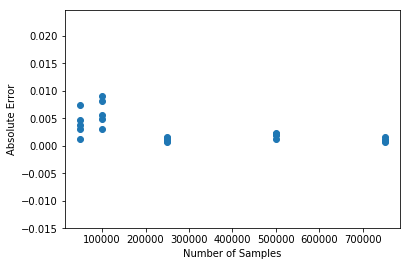

In [9]:
plt.scatter(data_store_x1, data_store_y1)
plt.xlabel('Number of Samples')
plt.ylabel('Absolute Error')
plt.show()

In [12]:
# Below is one of the transition matrices learned. Compare it to transition matrix A which was used to generate the sequence of observations
np.round(transition_matrices1[1], decimals=4)


array([[9.912e-01, 8.800e-03, 0.000e+00, 0.000e+00],
       [9.700e-03, 9.903e-01, 0.000e+00, 1.000e-04],
       [0.000e+00, 0.000e+00, 9.991e-01, 9.000e-04],
       [0.000e+00, 1.000e-04, 9.000e-04, 9.990e-01]])

Below we attempt to learn the HMM using three observations instead of four observations

The system is now degenerate -> two hidden states give rise to the same observation

the system is still deterministic -> each hidden state gives rise to a single observation 100% of the time

# We fit HMM to the 3 observation case using transition A and Emission C

In [22]:
data_store_x2 =[];
data_store_y2 =[];
transition_matrices2=[];
iterations = 5;
sample_size = [100000, 250000, 500000];
for i in enumerate(sample_size):
    for o in range(0,iterations):
        Output=np.asarray(Generatedata(A, C, i[1]))
        learnmodel2 = hmm.MultinomialHMM(n_components=4, n_iter = 400, init_params = "st", params = "st")
        learnmodel2.emissionprob_ = C
        learnmodel2.fit(Output, lengths=None)
        Error = np.sum(np.absolute(A -learnmodel2.transmat_))
        data_store_y2.append(Error)
        data_store_x2.append(i[1])
        transition_matrices2.append(learnmodel2.transmat_)

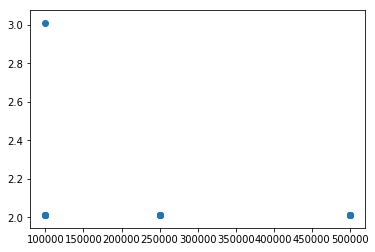

In [23]:
plt.scatter(data_store_x2, data_store_y2)
plt.show()

In [ ]:
np.round(transition_matrices1[1], decimals=4)

# We fit HMM to the 3 observation case using transition A and Emission C2

In [ ]:
data_store_x3 =[];
data_store_y3 =[];
transition_matrices3=[];
iterations = 5;
sample_size = [50000, 100000, 250000, 500000, 1000000];
for i in enumerate(sample_size):
    for o in range(0,iterations):
        Output=np.asarray(Generatedata(A, C2, i[1]))
        learnmodel3 = hmm.MultinomialHMM(n_components=4, n_iter = 400, init_params = "st", params = "st")
        learnmodel3.emissionprob_ = C
        learnmodel3.fit(Output, lengths=None)
        Error = np.sum(np.absolute(A -learnmodel3.transmat_))
        data_store_y3.append(Error)
        data_store_x3.append(i[1])
        transition_matrices3.append(learnmodel3.transmat_)

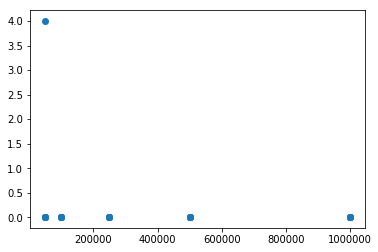

In [16]:
g = plt.scatter(data_store_x3, data_store_y3)
plt.show()

Above we see that the package fails to properly learn the correct transition matrix essentially everytime for the degenerate/deterministic case. However, we see that the model works somtimes for the stochastic/degenerate case.

Below we attempt to learn the HMM using two observations instead of four

the system is now doubly degenrate -> there are now 2 groups of 2 hidden states, the hidden states in each group give rise to the same observation.

the system is still deterministic -> each hidden state gives rise to a single observation 100% of the time

# We fit HMM to the 2 observation case using transition A and Emission D

In [41]:
data_store_x4 =[];
data_store_y4 =[];
transition_matrices4=[];
iterations = 5;
sample_size = [50000, 100000, 250000, 500000, 1000000];
for i in enumerate(sample_size):
    for o in range(0,iterations):
        Output=np.asarray(Generatedata(A, D, i[1]))
        learnmodel4 = hmm.MultinomialHMM(n_components=4, n_iter = 400, init_params = "st", params = "st")
        learnmodel4.emissionprob_ = D
        learnmodel4.fit(Output, lengths=None)
        Error = np.sum(np.absolute(A -learnmodel4.transmat_))
        data_store_y4.append(Error)
        data_store_x4.append(i[1])
        transition_matrices3.append(learnmodel4.transmat_)

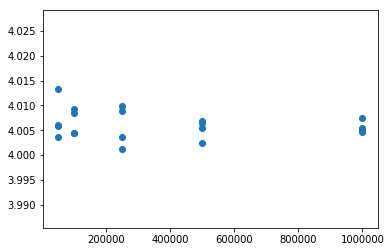

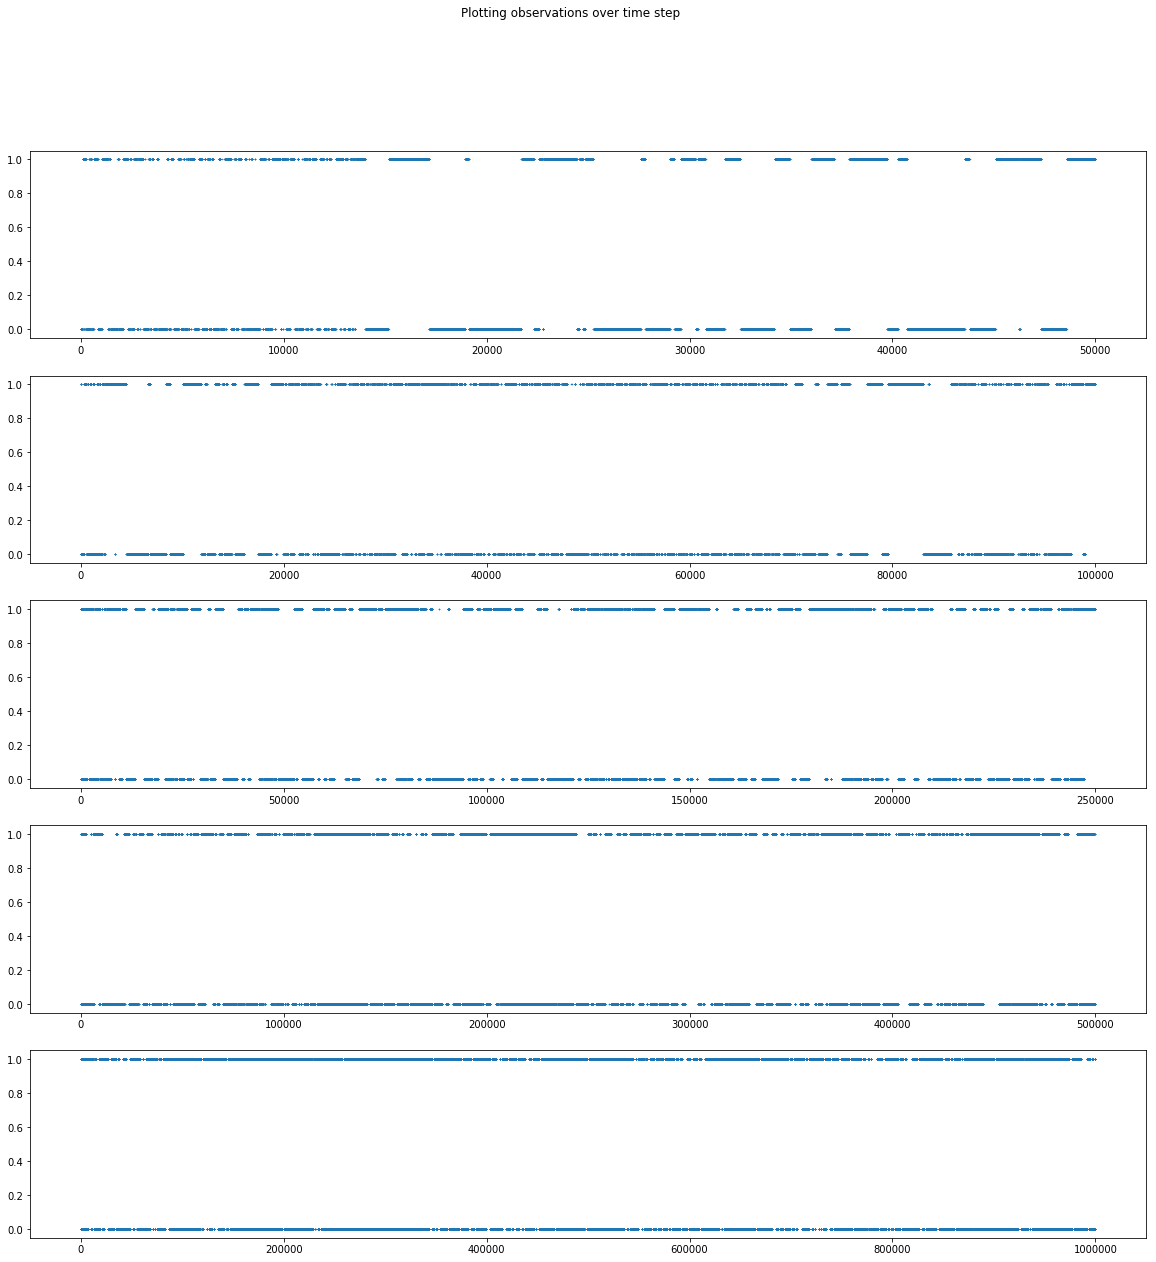

In [58]:
plt.scatter(data_store_x4, data_store_y4)
plt.show()

# We fit HMM to the 2 observation case using transition A2 and Emission D
## A2 is a transition matrix with a more extreme difference between k_fast & k_slow


In [64]:
data_store_x5 =[];
data_store_y5 =[];
transition_matrices5=[];
iterations = 5;
sample_size = [50000, 250000, 10000000];
for i in enumerate(sample_size):
    for o in range(0,iterations):
        Output=np.asarray(Generatedata(A2, D, i[1]))
        learnmodel5 = hmm.MultinomialHMM(n_components=4, n_iter = 400, init_params = "st", params = "st")
        learnmodel5.emissionprob_ = D
        learnmodel5.fit(Output, lengths=None)
        Error = np.sum(np.absolute(A2 -learnmodel5.transmat_))
        data_store_y5.append(Error)
        data_store_x5.append(i[1])
        transition_matrices5.append(learnmodel5.transmat_)

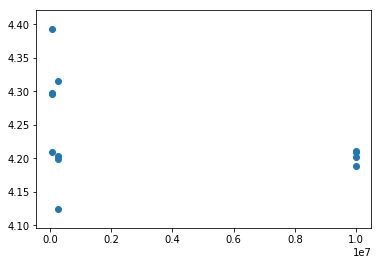

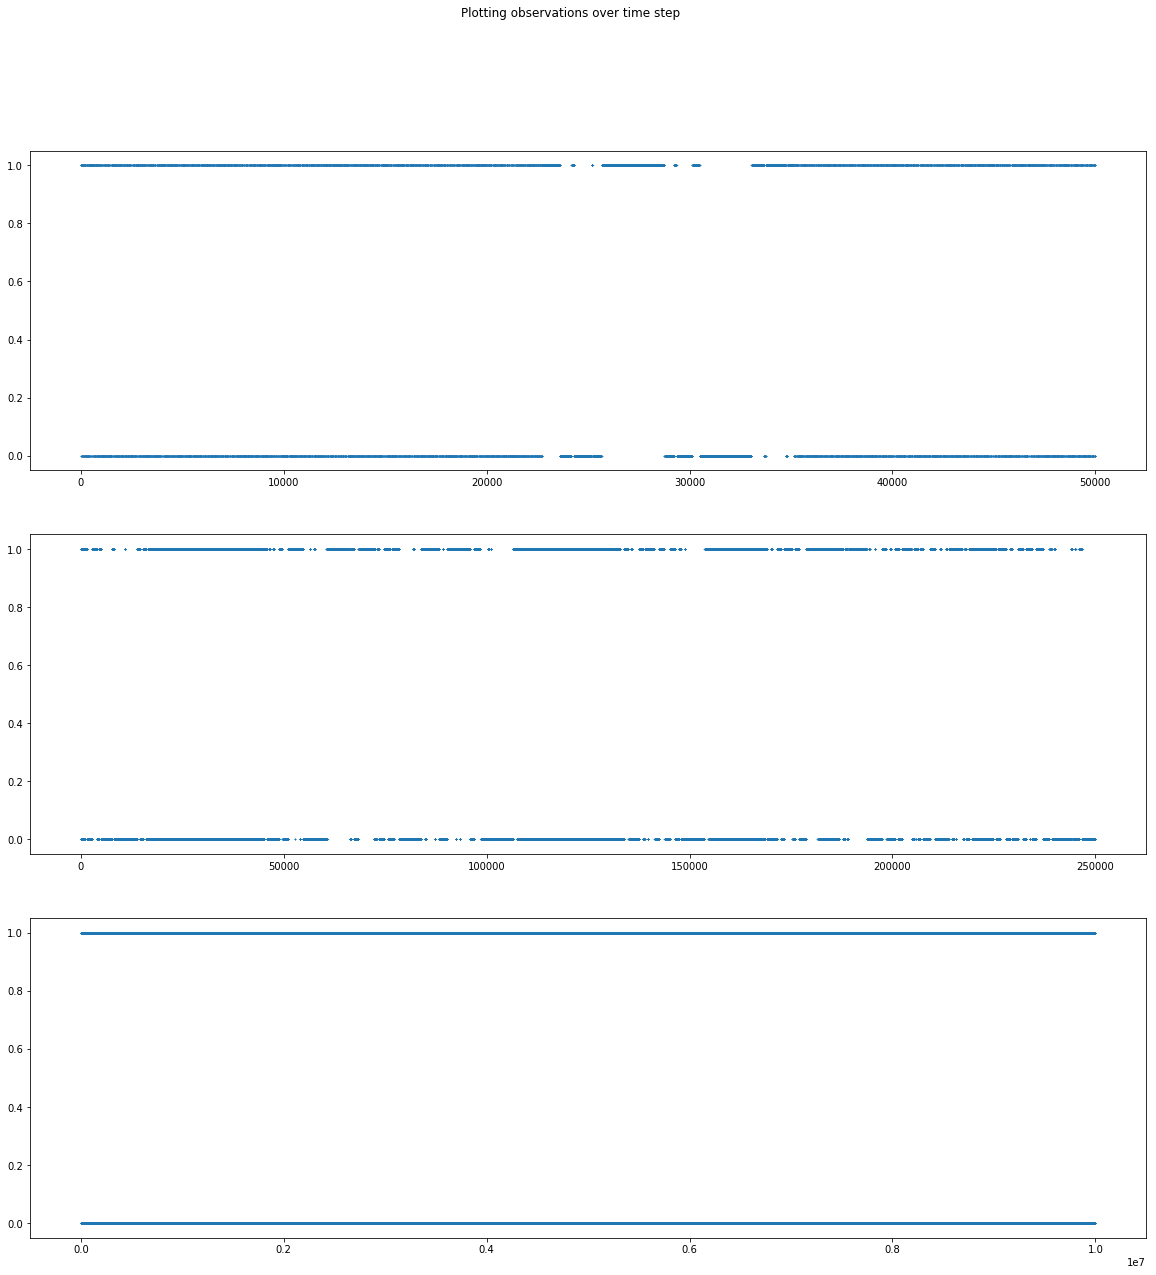

In [65]:
plt.scatter(data_store_x5, data_store_y5)
plt.show()

In [129]:
Output=np.asarray(Generatedata(A2, D, 10000000))
learnmodel = hmm.MultinomialHMM(n_components=4, n_iter = 500, init_params = "st", params = "st")
learnmodel.emissionprob_ = D
learnmodel.fit(Output, lengths=None)
Error = np.sum(np.absolute(A2 -learnmodel.transmat_))


4.194472890282521

In [130]:
learnmodel.score(Output, lengths=None)

-3238375.3068776014

In [131]:
Output=np.asarray(Generatedata(A2, D, 10000000))
learnmodel = hmm.MultinomialHMM(n_components=4, n_iter = 500, init_params = "s", params = "st")
learnmodel.emissionprob_ = D
learnmodel.transmat_ = A
learnmodel.fit(Output, lengths=None)
Error = np.sum(np.absolute(A2 -learnmodel.transmat_))

In [132]:
Error

0.0013277248985680778

In [133]:
learnmodel.score(Output, lengths=None)


-2433803.0479664323

In [144]:
Error=[];
Error1=[];
loglike=[];
loglike1=[];

for i in range(0, 10):
    Output=np.asarray(Generatedata(A2, D, 100000))
    learnmodel = hmm.MultinomialHMM(n_components=4, n_iter = 500, init_params = "st", params = "st")
    learnmodel.emissionprob_ = D
    learnmodel.fit(Output, lengths=None)
    Error.append(np.sum(np.absolute(A2 -learnmodel.transmat_)))
    loglike.append(learnmodel.score(Output, lengths=None))

    learnmodel1 = hmm.MultinomialHMM(n_components=4, n_iter = 500, init_params = "s", params = "st")
    learnmodel1.emissionprob_ = D
    learnmodel1.transmat_ = A
    learnmodel1.fit(Output, lengths=None)
    Error1.append(np.sum(np.absolute(A2 -learnmodel1.transmat_)))
    loglike.append(learnmodel1.score(Output, lengths=None))


In [152]:
time=[];
for i in range(0,10):
    time.append(1)
for i in range(0,10):
    time.append(2)
len(loglike)
len(time)

20

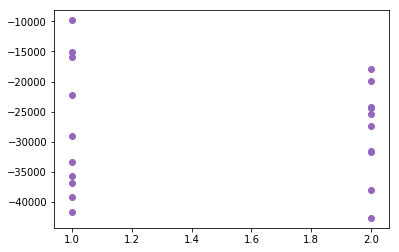

In [154]:
plt.scatter(time, loglike)

# We test the the log likelyhood between models biased towards the correct Transmat and those who are not biased towards the correct transmat

## Transmat_ A2 used Emission D used

##  1,000,000 & 10,000,000 Observations

In [157]:
Error=[];
Error1=[];
loglike=[];
loglike1=[];

for i in range(0, 10):
    Output=np.asarray(Generatedata(A2, D, 10000000))
    learnmodel = hmm.MultinomialHMM(n_components=4, n_iter = 500, init_params = "st", params = "st")
    learnmodel.emissionprob_ = D
    learnmodel.fit(Output, lengths=None)
    Error.append(np.sum(np.absolute(A2 -learnmodel.transmat_)))
    loglike.append(learnmodel.score(Output, lengths=None))

    learnmodel1 = hmm.MultinomialHMM(n_components=4, n_iter = 500, init_params = "s", params = "st")
    learnmodel1.emissionprob_ = D
    learnmodel1.transmat_ = A
    learnmodel1.fit(Output, lengths=None)
    Error1.append(np.sum(np.absolute(A2 -learnmodel1.transmat_)))
    loglike.append(learnmodel1.score(Output, lengths=None))


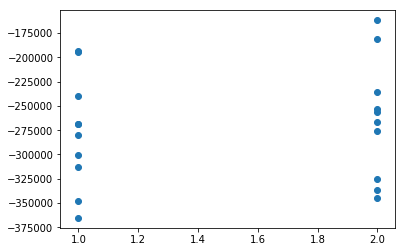

In [156]:
plt.scatter(time, loglike)
plt.show()

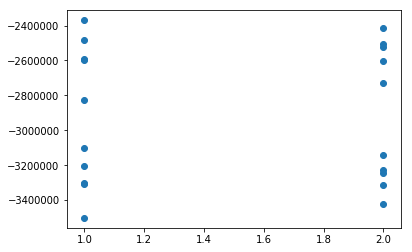

In [158]:
plt.scatter(time, loglike)
plt.show()

In [161]:
Error1

[0.0013978682316220419,
 0.0007310591096304199,
 0.0006454128658360262,
 0.0005099616734047844,
 0.0015154773203517552,
 0.0012073924296788178,
 0.0007892409995665689,
 0.0012851206004327194,
 8.102692705550917e-05,
 0.0012665787652188748]

# We test the the log likelyhood between models biased towards the correct Transmat and those who are not biased towards the correct transmat

## Transmat_ A used Emission D used

##  1,000,000 & 10,000,000 Observations

In [162]:
Error=[];
Error1=[];
loglike=[];
loglike1=[];

for i in range(0, 10):
    Output=np.asarray(Generatedata(A, D, 1000000))
    learnmodel = hmm.MultinomialHMM(n_components=4, n_iter = 200, init_params = "st", params = "st")
    learnmodel.emissionprob_ = D
    learnmodel.fit(Output, lengths=None)
    Error.append(np.sum(np.absolute(A -learnmodel.transmat_)))
    loglike.append(learnmodel.score(Output, lengths=None))

    learnmodel1 = hmm.MultinomialHMM(n_components=4, n_iter = 200, init_params = "s", params = "st")
    learnmodel1.emissionprob_ = D
    learnmodel1.transmat_ = A2
    learnmodel1.fit(Output, lengths=None)
    Error1.append(np.sum(np.absolute(A -learnmodel1.transmat_)))
    loglike.append(learnmodel1.score(Output, lengths=None))

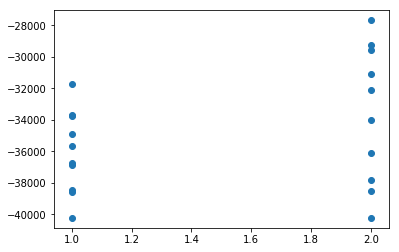

In [163]:
plt.scatter(time, loglike)
plt.show()

In [165]:
Error

[4.008997739500269,
 4.00762239218563,
 4.008359969785349,
 4.006458673313936,
 4.007198339474149,
 4.0080728591536126,
 4.00900879425889,
 4.004887700542348,
 4.00659976148726,
 4.005464878257982]

In [166]:
Error=[];
Error1=[];
loglike=[];
loglike1=[];

for i in range(0, 10):
    Output=np.asarray(Generatedata(A, D, 10000000))
    learnmodel = hmm.MultinomialHMM(n_components=4, n_iter = 200, init_params = "st", params = "st")
    learnmodel.emissionprob_ = D
    learnmodel.fit(Output, lengths=None)
    Error.append(np.sum(np.absolute(A2 -learnmodel.transmat_)))
    loglike.append(learnmodel.score(Output, lengths=None))

    learnmodel1 = hmm.MultinomialHMM(n_components=4, n_iter = 200, init_params = "s", params = "st")
    learnmodel1.emissionprob_ = D
    learnmodel1.transmat_ = A2
    learnmodel1.fit(Output, lengths=None)
    Error1.append(np.sum(np.absolute(A -learnmodel1.transmat_)))
    loglike.append(learnmodel1.score(Output, lengths=None))

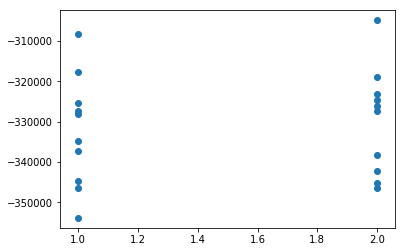

In [167]:
plt.scatter(time, loglike)
plt.show()

In [169]:
Error

[4.007095800720897,
 4.006456199785919,
 4.00610940952048,
 4.0068112792542365,
 4.006740986608224,
 4.006491928977724,
 4.00597610470863,
 4.006806412749376,
 4.006643676322275,
 4.006765720405795]

# We test the the log likelyhood between models biased towards the correct Transmat and those who are not biased towards the correct transmat

## Transmat_ A1 used Emission D used

##  1,000,000 Observations

In [170]:
Error=[];
Error1=[];
loglike=[];
loglike1=[];

for i in range(0, 10):
    Output=np.asarray(Generatedata(A1, D, 1000000))
    learnmodel = hmm.MultinomialHMM(n_components=4, n_iter = 200, init_params = "st", params = "st")
    learnmodel.emissionprob_ = D
    learnmodel.fit(Output, lengths=None)
    Error.append(np.sum(np.absolute(A2 -learnmodel.transmat_)))
    loglike.append(learnmodel.score(Output, lengths=None))

    learnmodel1 = hmm.MultinomialHMM(n_components=4, n_iter = 200, init_params = "s", params = "st")
    learnmodel1.emissionprob_ = D
    learnmodel1.transmat_ = A2
    learnmodel1.fit(Output, lengths=None)
    Error1.append(np.sum(np.absolute(A1 -learnmodel1.transmat_)))
    loglike.append(learnmodel1.score(Output, lengths=None))

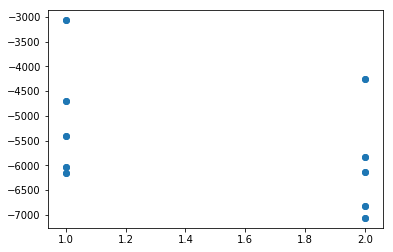

In [171]:
plt.scatter(time, loglike)
plt.show()

In [172]:
Error1

[0.5293106072671989,
 0.5285257409101827,
 0.6371984642116564,
 0.9512828527452022,
 1.958037777482607,
 0.9350658175943094,
 0.5574312203614453,
 0.4289002893816204,
 0.6022145225586123,
 0.8019441770839543]

# We test the the log likelyhood between models biased towards the correct Transmat and those who are not biased towards the correct transmat

## Transmat_ A1 used Emission D used

## 10,000,000 & 20,000,000 Observations

In [178]:
Error=[];
Error1=[];
loglike=[];
loglike1=[];

for i in range(0, 5):
    Output=np.asarray(Generatedata(A1, D, 20000000))
    learnmodel = hmm.MultinomialHMM(n_components=4, n_iter = 250, init_params = "st", params = "st")
    learnmodel.emissionprob_ = D
    learnmodel.fit(Output, lengths=None)
    Error.append(np.sum(np.absolute(A2 -learnmodel.transmat_)))
    loglike.append(learnmodel.score(Output, lengths=None))

    learnmodel1 = hmm.MultinomialHMM(n_components=4, n_iter = 250, init_params = "s", params = "st")
    learnmodel1.emissionprob_ = D
    learnmodel1.transmat_ = A
    learnmodel1.fit(Output, lengths=None)
    Error1.append(np.sum(np.absolute(A1 -learnmodel1.transmat_)))
    loglike.append(learnmodel1.score(Output, lengths=None))

In [176]:
time2=[];
for i in range(0,5):
    time2.append(1)
for i in range(0,5):
    time2.append(2)

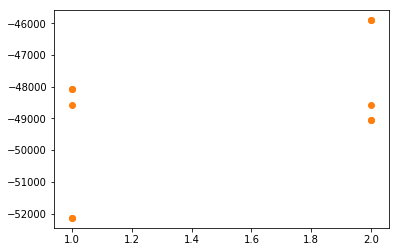

In [177]:
plt.scatter(time2, loglike)
plt.show()

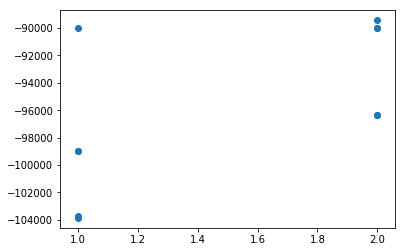

In [179]:
plt.scatter(time2, loglike)
plt.show()

# We test the the log likelyhood between models biased towards the correct Transmat and those who are not biased towards the correct transmat

## Transmat_ A3 used Emission D used

## 10,000,000 Observations

In [181]:
Error2=[];
Error3=[];
loglike2=[];
loglike3=[];

for i in range(0, 4):
    Output=np.asarray(Generatedata(A3, D, 10000000))
    learnmodel = hmm.MultinomialHMM(n_components=4, n_iter = 250, init_params = "st", params = "st")
    learnmodel.emissionprob_ = D
    learnmodel.fit(Output, lengths=None)
    Error2.append(np.sum(np.absolute(A3 -learnmodel.transmat_)))
    loglike2.append(learnmodel.score(Output, lengths=None))

    learnmodel1 = hmm.MultinomialHMM(n_components=4, n_iter = 250, init_params = "s", params = "st")
    learnmodel1.emissionprob_ = D
    learnmodel1.transmat_ = A2
    learnmodel1.fit(Output, lengths=None)
    Error3.append(np.sum(np.absolute(A3 -learnmodel1.transmat_)))
    loglike2.append(learnmodel1.score(Output, lengths=None))

In [182]:
time2=[];
for i in range(0,4):
    time2.append(1)
for i in range(0,4):
    time2.append(2)

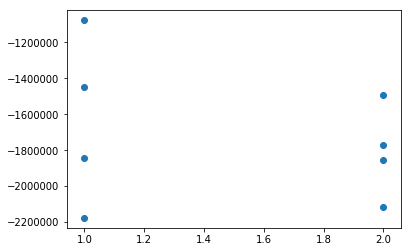

In [183]:
plt.scatter(time2, loglike2)
plt.show()

In [185]:
learnmodel.transmat_

array([[0.47293484, 0.02706516, 0.47293484, 0.02706516],
       [0.02737256, 0.47262744, 0.02737256, 0.47262744],
       [0.47293484, 0.02706516, 0.47293484, 0.02706516],
       [0.02737256, 0.47262744, 0.02737256, 0.47262744]])

In [189]:
Error2=[];
Error3=[];
loglike2=[];
loglike3=[];

for i in range(0, 4):
    Output=np.asarray(Generatedata(A1, D, 10000000))
    learnmodel = hmm.MultinomialHMM(n_components=4, n_iter = 250, init_params = "st", params = "st")
    learnmodel.emissionprob_ = D
    learnmodel.fit(Output, lengths=None)
    Error2.append(np.sum(np.absolute(A1 -learnmodel.transmat_)))
    loglike2.append(learnmodel.score(Output, lengths=None))

    learnmodel1 = hmm.MultinomialHMM(n_components=4, n_iter = 250, init_params = "s", params = "st")
    learnmodel1.emissionprob_ = D
    learnmodel1.transmat_ = A2
    learnmodel1.fit(Output, lengths=None)
    Error3.append(np.sum(np.absolute(A1 -learnmodel1.transmat_)))
    loglike2.append(learnmodel1.score(Output, lengths=None))

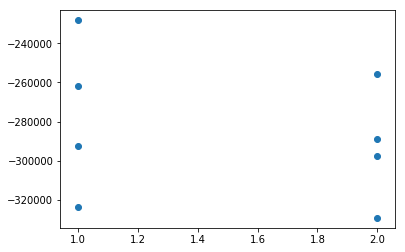

In [190]:
plt.scatter(time2, loglike2)
plt.show()

In [1]:
Output

NameError: name 'Output' is not defined

In [3]:
matrix = np.random.rand(4,4)
matrix = matrix/matrix.sum(axis=1)[:, None]

In [4]:
matrix

array([[0.13973912, 0.09820025, 0.29211488, 0.46994575],
       [0.21484899, 0.31700342, 0.19686748, 0.2712801 ],
       [0.48559821, 0.03665433, 0.35845295, 0.11929452],
       [0.25602826, 0.24018229, 0.18410984, 0.31967961]])

In [15]:
Output=np.asarray(Generatedata(A, D, i[1]))
learnmodel5 = hmm.MultinomialHMM(n_components=4, n_iter = 400, init_params = "st", params = "st")
learnmodel5.emissionprob_ = D
learnmodel5.fit(Output, lengths=None)

MultinomialHMM(algorithm='viterbi', init_params='st', n_components=4,
        n_iter=400, params='st',
        random_state=<mtrand.RandomState object at 0x000001C915A739D8>,
        startprob_prior=1.0, tol=0.01, transmat_prior=1.0, verbose=False)

In [32]:
np.round(learnmodel5.transmat_, decimals=4)

array([[0.4969, 0.0031, 0.4969, 0.0031],
       [0.003 , 0.497 , 0.003 , 0.497 ],
       [0.4969, 0.0031, 0.4969, 0.0031],
       [0.003 , 0.497 , 0.003 , 0.497 ]])

In [30]:
Output=np.asarray(Generatedata(A, D, 1000000))
learnmodel6 = hmm.MultinomialHMM(n_components=4, n_iter = 800, init_params = "s", params = "st")
learnmodel6.emissionprob_ = D
learnmodel6.transmat_ = A2
learnmodel6.fit(Output, lengths=None)

MultinomialHMM(algorithm='viterbi', init_params='s', n_components=4,
        n_iter=800, params='st',
        random_state=<mtrand.RandomState object at 0x000001C915A739D8>,
        startprob_prior=1.0, tol=0.01, transmat_prior=1.0, verbose=False)

In [35]:
np.round(learnmodel6.transmat_, decimals =4)

array([[9.901e-01, 9.900e-03, 0.000e+00, 0.000e+00],
       [9.800e-03, 9.901e-01, 0.000e+00, 1.000e-04],
       [0.000e+00, 0.000e+00, 9.989e-01, 1.100e-03],
       [0.000e+00, 1.000e-04, 1.100e-03, 9.988e-01]])

750000

In [37]:
Output=np.asarray(Generatedata(A, C, 1000000))
learnmodel5 = hmm.MultinomialHMM(n_components=4, n_iter = 400, init_params = "st", params = "st")
learnmodel5.emissionprob_ = C
learnmodel5.fit(Output, lengths=None)

MultinomialHMM(algorithm='viterbi', init_params='st', n_components=4,
        n_iter=400, params='st',
        random_state=<mtrand.RandomState object at 0x000001C915A739D8>,
        startprob_prior=1.0, tol=0.01, transmat_prior=1.0, verbose=False)

In [39]:
np.round(learnmodel5.transmat_, decimals=4)

array([[9.901e-01, 9.900e-03, 0.000e+00, 0.000e+00],
       [1.030e-02, 9.896e-01, 0.000e+00, 1.000e-04],
       [0.000e+00, 0.000e+00, 9.990e-01, 1.000e-03],
       [0.000e+00, 1.000e-04, 1.000e-03, 9.988e-01]])

In [41]:
Output=np.asarray(Generatedata(A, C1, 1000000))
learnmodel8 = hmm.MultinomialHMM(n_components=4, n_iter = 700, init_params = "st", params = "st")
learnmodel8.emissionprob_ = C1
learnmodel8.fit(Output, lengths=None)

MultinomialHMM(algorithm='viterbi', init_params='st', n_components=4,
        n_iter=700, params='st',
        random_state=<mtrand.RandomState object at 0x000001C915A739D8>,
        startprob_prior=1.0, tol=0.01, transmat_prior=1.0, verbose=False)

In [43]:
np.round(learnmodel8.transmat_, decimals=4)

array([[9.901e-01, 2.700e-03, 0.000e+00, 7.200e-03],
       [2.800e-03, 5.451e-01, 8.000e-04, 4.512e-01],
       [0.000e+00, 9.000e-04, 9.988e-01, 3.000e-04],
       [7.100e-03, 4.553e-01, 2.000e-04, 5.373e-01]])

In [46]:
Output=np.asarray(Generatedata(A, D, 100000))


In [54]:

learnmodel9 = hmm.MultinomialHMM(n_components=4, n_iter = 250, init_params = "s", params = "s")
learnmodel9.emissionprob_ = D
learnmodel9.transmat_ = A
learnmodel9.fit(Output, lengths=None)

MultinomialHMM(algorithm='viterbi', init_params='s', n_components=4,
        n_iter=250, params='s',
        random_state=<mtrand.RandomState object at 0x000001C915A739D8>,
        startprob_prior=1.0, tol=0.01, transmat_prior=1.0, verbose=False)

In [55]:
learnmodel9.score(Output, lengths=None)

-3579.429761304585

In [56]:

learnmodel9 = hmm.MultinomialHMM(n_components=4, n_iter = 250, init_params = "st", params = "st")
learnmodel9.emissionprob_ = D
learnmodel9.fit(Output, lengths=None)

MultinomialHMM(algorithm='viterbi', init_params='st', n_components=4,
        n_iter=250, params='st',
        random_state=<mtrand.RandomState object at 0x000001C915A739D8>,
        startprob_prior=1.0, tol=0.01, transmat_prior=1.0, verbose=False)

In [57]:
learnmodel9.score(Output, lengths=None)

-3757.8637307966196

In [58]:
learnmodel9.transmat_

array([[0.49666875, 0.00333125, 0.49666875, 0.00333125],
       [0.00288139, 0.49711861, 0.00288139, 0.49711861],
       [0.49666875, 0.00333125, 0.49666875, 0.00333125],
       [0.00288139, 0.49711861, 0.00288139, 0.49711861]])

In [59]:
Output=np.asarray(Generatedata(A, F, 100000))
learnmodel9 = hmm.MultinomialHMM(n_components=4, n_iter = 250, init_params = "st", params = "st")
learnmodel9.emissionprob_ = F
learnmodel9.fit(Output, lengths=None)

MultinomialHMM(algorithm='viterbi', init_params='st', n_components=4,
        n_iter=250, params='st',
        random_state=<mtrand.RandomState object at 0x000001C915A739D8>,
        startprob_prior=1.0, tol=0.01, transmat_prior=1.0, verbose=False)

In [62]:
np.round(learnmodel9.transmat_, decimals = 3)

array([[0.499, 0.002, 0.499, 0.001],
       [0.005, 0.991, 0.005, 0.   ],
       [0.499, 0.002, 0.499, 0.001],
       [0.   , 0.   , 0.   , 0.999]])